# Econometría Aplicada 1 (Taller) - Examen Final
Importar librerías

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Ejercicio 3: Índice hedónico de computadoras
Cargar datos

In [148]:
df = pd.read_csv('../dat/chow.txt', sep='\t')

### (a) Construcción de atributos
Crear los atributos necesarios

In [149]:
# Agregar término constante
df['CONST'] = 1

# Crear atributos logarítmicos
for col in ['RENT','MULT','ACCESS','ADD']:
    df['LN'+col] = np.log(df[col])
    
# Crear Memory Space
df['LNMEM'] = np.log(df[['WORDS','BINARY','DIGITS']].product(axis=1))

# Crear dummies por año (61, 62, ..., 65)
df['D'] = np.where(df['YEAR'].lt(61), 60, df['YEAR'])
df = pd.get_dummies(df, prefix='D', prefix_sep='_', columns=['D'], drop_first=True)

Comparación de matríces de correlación en los periodos
- [1954-1959]

In [150]:
c1 = df.loc[df['YEAR'].between(54,59), 'LNRENT':'LNMEM'].corr()
c1.round(2)

,LNRENT,LNMULT,LNACCESS,LNADD,LNMEM
LNRENT,1.00,-0.87,-0.85,-0.84,0.88
LNMULT,-0.87,1.00,0.86,0.98,-0.74
LNACCESS,-0.85,0.86,1.00,0.85,-0.61
LNADD,-0.84,0.98,0.85,1.00,-0.73
LNMEM,0.88,-0.74,-0.61,-0.73,1.00


- [1960-1965]

In [151]:
c2 = df.loc[df['YEAR'].between(60,65), 'LNRENT':'LNMEM'].corr()
c2.round(2)

,LNRENT,LNMULT,LNACCESS,LNADD,LNMEM
LNRENT,1.00,-0.63,-0.58,-0.63,0.88
LNMULT,-0.63,1.00,0.77,0.94,-0.57
LNACCESS,-0.58,0.77,1.00,0.81,-0.46
LNADD,-0.63,0.94,0.81,1.00,-0.56
LNMEM,0.88,-0.57,-0.46,-0.56,1.00


Los coeficientes de correlación entre las siguientes variables cambiaron menos de 10 puntos porcentuales entre ambos periodos:
1. `LNRENT` y `LNMEM`
1. `LNMULT` y `LNACCESS`
1. `LNMULT` y `LNADD`
1. `LNACCESS` y `LNADD`

Los demás pares de variables cambian en 10 o más puntos porcentuales.

En general, ambas matríces de correlación se parecen. Sin embargo, considero que hay diferencias importantes entre ambos periodos. En particular, hay menos pares de variables con coeficientes de correlación mayores a 0.7 en valor absoluto en el segundo periodo.

Igualmente, creo que Chow estaba en lo correcto al preocuparse por la posibilidad de un problema de multicolinealidad, pues todos los pares de variables excepto por `LNMEM` y `LNACCESS` tienen un coeficiente de correlación de almenos 0.7 en valor absoluto en el periodo previo a 1960.

Las correlaciones siguen siendo altas de 1960 en adelante. Sin embargo, los coeficientes tienden a disminuir en esta ventana de tiempo.

### (b) Regresión de Chow

In [152]:
# Objetos para regresión
feats = ['CONST','D_61','D_62','D_63','D_64','D_65','LNMULT','LNMEM','LNACCESS']
targt = 'LNRENT'
X = df.loc[df['YEAR'].ge(60), feats]
y = df.loc[df['YEAR'].ge(60), targt]

# Modelo de Chow
m1 = sm.OLS(endog=y, exog=X)
m1_res = m1.fit()

In [153]:
print(m1_res.summary().tables[1])
print('Observations:', int(m1_res.nobs))
print('R2:', round(m1_res.rsquared, 3))

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CONST         -0.1045      0.315     -0.332      0.741      -0.732       0.523
D_61          -0.1398      0.166     -0.840      0.404      -0.472       0.192
D_62          -0.4891      0.174     -2.815      0.006      -0.835      -0.143
D_63          -0.5938      0.166     -3.575      0.001      -0.925      -0.263
D_64          -0.9248      0.166     -5.561      0.000      -1.256      -0.593
D_65          -1.1632      0.166     -7.003      0.000      -1.494      -0.832
LNMULT        -0.0654      0.028     -2.301      0.024      -0.122      -0.009
LNMEM          0.5793      0.035     16.369      0.000       0.509       0.650
LNACCESS      -0.1406      0.029     -4.794      0.000      -0.199      -0.082
Observations: 82
R2: 0.908


Índice de precios usando método alternativo

In [154]:
t = pd.concat([pd.Series([1], ['D_60']), np.exp(m1_res.params['D_61':'D_65'])]).to_frame()
t.columns=['Price Index (exp)']
t['Price Index (Chow)'] = [1,.8438,.6414,.5330,.3906,.3188]
t.round(4)

,Price Index (exp),Price Index (Chow)
D_60,1.0000,1.0000
D_61,0.8695,0.8438
D_62,0.6132,0.6414
D_63,0.5522,0.5330
D_64,0.3966,0.3906
D_65,0.3125,0.3188


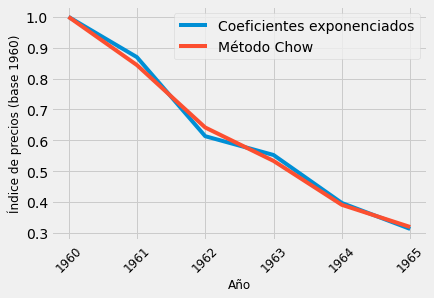

In [155]:
plt.plot(t.index, t['Price Index (exp)'], label='Coeficientes exponenciados')
plt.plot(t.index, t['Price Index (Chow)'], label='Método Chow')
plt.xticks(t.index, labels=range(1960,1966), rotation=45, fontsize=12)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Índice de precios (base 1960)', fontsize=12)
plt.legend()
plt.show()

El índice de precios usando el método de exponenciar los coeficientes de efectos fijos por año da resultados muy similares al método de Chow. Ambas series muestran la misma tendencia a la baja y las diferencias son negligibles.

### (c) Especificación alternativa
Prueba de que la especificación de Chow asume que el logaritmo `BINARY * DIGITS` y de `WORDS` tienen la misma pendiente:
$$\beta \ln(MEM) = \beta \ln(WORDS \times BINARY \times DIGITS) = \beta \ln(WORDS) + \beta \ln(BINARY \times DIGITS)$$

In [ ]:
# Separar LNMEM en dos términos independientes
df = df.assign(LNLENGTH=np.log(df['BINARY'].multiply(df['DIGITS'])),
               LNWORDS=np.log(df['WORDS']))

# Objetos para regresión
feats = ['CONST','D_61','D_62','D_63','D_64','D_65','LNMULT','LNLENGTH','LNWORDS','LNACCESS']
X = df.loc[df['YEAR'].ge(60), feats]
y = df.loc[df['YEAR'].ge(60), 'LNRENT']

# Modelo alternativo
m2 = sm.OLS(y, X)
m2_res = m2.fit()
print(m2_res.summary().tables[1])

Probar si los coeficientes son distintos entre sí:

In [ ]:
print('R2 adj de modelo 1:', round(m1_res.rsquared_adj, 4))
print('R2 adj de modelo 2:', round(m1_res.rsquared_adj, 4))

# Probar si los coeficientes son distintos
m2_res.t_test([0,0,0,0,0,0,0,1,-1,0]).summary()

Ambas especificaciones resultan en prácticamente el mismo coeficiente $R^2$ adjustado, así que la especificación no tienen un impacto sobre el desempeño predictivo del modelo. Sin embargo, los coeficientes de `LNLENGTH` y de `LNWORDS` son muy parecidos y no podemos rechazar la hipótesis nula de que tengan el mismo efecto sobre la variable dependiente.

Por cuestiones de parsimonía, prefiero el primer modelo.

### (d) Efectos fijos sin término constante
Usar todas las observaciones y crear efectos fijos por año (sin constante)

In [ ]:
# Objetos para regresión
X = pd.concat([pd.get_dummies(df['YEAR'], prefix='D'), df[['LNMULT','LNMEM','LNACCESS']]], axis=1)
y = df['LNRENT']

# Modelo
m3 = sm.OLS(y, X)
m3_res = m3.fit()
print(m3_res.summary().tables[1])

In [ ]:
t = np.exp(m3_res.params['D_54':'D_65'] - m3_res.params['D_54']).to_frame()
t.columns = ['Price Index (base 1954)']
t['Price Index (base 1965)'] = t['Price Index (base 1954)'].div(t.loc['D_65'].item())
(t * 100).round(0)

La segunda columna es igual a la primera salvo porque renormalicé la serie a 1965.

Con respecto a la serie de Triplett, mis estimaciones resultan en índices más bajos. Por ejemplo, en 1954, el precio de una computadora era 10 veces el índice de 1965. De acuerdo a los coeficientes estimados por Triplett, el precio de la misma computadora era 13.20 veces el precio de 1965.

### (e) Heteroscedasticidad

In [ ]:
# Objetos para regresión
w = np.sqrt(df.loc[df['YEAR'].ge(60), 'VOLUME'])
X = df.loc[df['YEAR'].ge(60), m1.exog_names]
y = df.loc[df['YEAR'].ge(60), 'LNRENT']

# Modelo
m4 = sm.OLS(y, X.multiply(w, axis=0), hasconst=True)
m4_res = m4.fit()
print(m4_res.summary().tables[1])

Me parece que este método no es correcto porque el libro muestra un ejemplo donde $Y_i$ es el precio promedio del modelo $i$ en la siguiente especificación:
$$Y_i = \beta_0 + \beta_1 X_{1,i} + ... + u_i$$

Nuestra especificación usa $\ln(Y_i)$ como variable dependiente, la cual no es una transformación lineal. Es decir, $\sqrt{S_m} \ \times \ln(Y_i) \neq \ln\big(Y_i \times \sqrt{S_m} \ \big)$.

Solo deberíamos de aplicar esta transformación cuando modelamos el precio de las computadoras, no el logaritmo del precio.

Como se muestra a continuación, el método que no usa este atajo coincide casi puntualmente con la estimación original salvo que los errores estándar son más grandes en la mayoría de los casos.

In [ ]:
m5 = sm.OLS(y, X, weights=w).fit()
print(m5.summary().tables[1])

## Ejercicio 4: IBM
Cargar datos

In [ ]:
df = pd.read_csv('../dat/cole.txt', sep='\t')

### (a) Regresión
La pregunta indica que tengo que usar los datos viejos.

In [ ]:
# Nuevas columnas
df = df.assign(CONST=1,
               LNOLDPR=np.log(df['OLDPR']),
               LNPRICE=np.log(df['PRICE']),
               LNOLDSP=np.log(df['OLDSP']),
               LNSPEED=np.log(df['SPEED']),
               LNCAP=np.log(df['CAP']))

# Objetos para regresión
feats = ['CONST','D73','D74','D75','D76','D77','D78','D79','D80',
         'D81','D82','D83','D84','LNOLDSP','LNCAP']
X = df[feats]
y = df['LNOLDPR']

# Modelo
m1 = sm.OLS(y, X).fit()
print(m1.summary().tables[1])
print('R2:', m1.rsquared)

### (b) Misma regresión usando nuevos datos

In [ ]:
feats = ['CONST','D73','D74','D75','D76','D77','D78','D79','D80',
         'D81','D82','D83','D84','LNSPEED','LNCAP']
X = df[feats]
y = df['LNPRICE']

# Modelo nuevo
m2 = sm.OLS(y, X).fit()
print(m2.summary().tables[1])
print('R2:', m2.rsquared)

Todos los coeficientes se mantienen cercanos a lo que solían ser. En particular, los coeficientes estimados en la vieja y nueva regresión resultan en que las mismas variables tienen un efecto estadísticamente significativo.

El efecto marginal de `LNSPEED` bajo, pero no mucho.

### (c) Homogeneidad
$H_0$: $\beta_{lnspeed} + \beta_{lncap} = 1$

$H_1$: $\beta_{lnspeed} + \beta_{lncap} \neq 1$

In [ ]:
m2.t_test(np.zeros(len(m2.params)-2).astype(int).tolist() + [1, 1])

Podemos rechazar la hipótesis nula de que los coeficientes sean iguales a uno. Esto significa que al multiplicar ambas variables por $\lambda$, el precio se multiplicaría por un factor menor a $\lambda$.

### (d) Efectos anuales constantes
Si reemplazamos los efectos fijos anuales por una sola columna de tiempo, estamos asumiendo que el paso del tiempo tiene rendimientos constantes sobre el logaritmo del precio porque estamos estimando un solo coeficiente.

In [ ]:
# Nueva variable de rendimientos constantes
df['TIME'] = df['YEAR'] - 1971

# Objetos para regresión
X = df[['CONST','TIME','LNSPEED','LNCAP']]
y = df['LNPRICE']

# Modelo
m3 = sm.OLS(y, X).fit()
print(m3.summary().tables[1])

Haré la prueba $F$ de que todos los coeficientes sean iguales al $\beta_{time}$ del modelo restringido.

In [ ]:
# Efecto marginal anual
b = m3.params['TIME']

# Matriz de restricciones
L = np.matrix([[0,1-b,0,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,1-b,0,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,1-b,0,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,1-b,0,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,1-b,0,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,1-b,0,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,1-b,0,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,1-b,0,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,1-b,0,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,1-b,0,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,1-b,0,0,0],
               [0,0,0,0,0,0,0,0,0,0,0,0,1-b,0,0]])

# Prueba
f = m2.f_test(L)
print('F-stat:', round(f.statistic.item(), 4))
print('p-value:', round(f.pvalue.item(), 4))

Podemos rechazar la hipótesis de que los rendimientos marginales sobre el tiempo sean constantes e iguales al coeficiente del modelo del inciso anterior.

## Ejercicio 5: Estabilidad de precios hedónicos
Definir función para comparar modelo restringido contra no restringido:

In [2]:
def f_test(unrest, rest):
    ussr = np.power(unrest.resid, 2).sum()
    rssr = np.power(rest.resid, 2).sum()
    n = unrest.nobs
    k = len(unrest.params.index)
    q = k - len(np.intersect1d(unrest.params.index, rest.params.index))
    f = ((rssr - ussr) / q) / (ussr / (n - k))
    p = stats.f(dfn=q, dfd=n - k).sf(f)
    return (f, q, n - k, p)

Reconstruir datos de pregunta 3

In [3]:
# Leer datos
df = pd.read_csv('../dat/chow.txt', sep='\t')

# Agregar término constante
df['CONST'] = 1

# Crear atributos logarítmicos
for col in ['RENT','MULT','ACCESS','ADD']:
    df['LN'+col] = np.log(df[col])
    
# Crear Memory Space
df['LNMEM'] = np.log(df[['WORDS','BINARY','DIGITS']].product(axis=1))

# Crear dummies por año
df['D'] = df['YEAR']
df = pd.get_dummies(df, prefix='D', prefix_sep='_', columns=['D'], drop_first=False)

### (a) Regresiones 60-65

Modelo restringido

In [4]:
# Objetos para regresión
feats = ['CONST','D_61','D_62','D_63','D_64','D_65','LNMULT','LNMEM','LNACCESS']
targt = 'LNRENT'
X = df.loc[df['YEAR'].ge(60), feats]
y = df.loc[df['YEAR'].ge(60), targt]

# Modelo restringido
m1 = sm.OLS(endog=y, exog=X).fit()

Modelo no restringido

In [5]:
# Objetos para regresión
x = ['CONST','D_61','D_62','D_63','D_64','D_65','LNMULT','LNMEM','LNACCESS']
X = df.loc[df['YEAR'].ge(60), x].copy()
for year in range(61,66):
    y = str(year)
    f = ['LNMULT','LNMEM','LNACCESS']
    X[['LNMULT_'+y,'LNMEM_'+y,'LNACCESS_'+y]] = X[f].multiply(X['D_'+y], axis=0)
y = df.loc[df['YEAR'].ge(60), 'LNRENT']

# Regresión
m2 = sm.OLS(endog=y, exog=X).fit()
print(m2.summary().tables[1])

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
CONST           1.2047      1.381      0.872      0.387      -1.560       3.970
D_61           -1.1999      1.755     -0.684      0.497      -4.713       2.313
D_62           -3.6092      1.683     -2.145      0.036      -6.978      -0.241
D_63           -2.0055      1.651     -1.215      0.229      -5.311       1.300
D_64           -2.7946      1.524     -1.833      0.072      -5.846       0.256
D_65           -2.5584      1.461     -1.751      0.085      -5.482       0.366
LNMULT         -0.1523      0.091     -1.678      0.099      -0.334       0.029
LNMEM           0.4234      0.162      2.619      0.011       0.100       0.747
LNACCESS       -0.1208      0.070     -1.713      0.092      -0.262       0.020
LNMULT_61       0.0908      0.124      0.732      0.467      -0.157       0.339
LNMEM_61        0.1273      0.204      0

Prueba F

In [6]:
f_test(unrest=m2, rest=m1)

(0.7431887126370076, 15, 58.0, 0.7312392203957196)

El estadístico $F$ es 0.74 y la probabilidad de observar un resultado así o más extremo dada la hipótesis nula es 0.73.

Por ende, no rechazo que todas las pendientes sean iguales simultaneamente.

### (b) Regresiones 55-65
Modelo no restringido

In [7]:
# Objetos para regresión
x = ['CONST','D_55','D_56','D_57','D_58','D_59','LNMULT','LNMEM','LNACCESS']
X = df.loc[df['YEAR'].lt(60), x].copy()
for year in range(55,60):
    y = str(year)
    f = ['LNMULT','LNMEM','LNACCESS']
    X[['LNMULT_'+y,'LNMEM_'+y,'LNACCESS_'+y]] = X[f].multiply(X['D_'+y], axis=0)
y = df.loc[df['YEAR'].lt(60), 'LNRENT']

# Regresión
m3 = sm.OLS(endog=y, exog=X).fit()
print(m3.summary().tables[1])

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
CONST           2.5659      2.542      1.009      0.321      -2.619       7.750
D_55           -0.4309      2.983     -0.144      0.886      -6.514       5.652
D_56           -1.8915      2.776     -0.681      0.501      -7.553       3.770
D_57           -1.5191      3.010     -0.505      0.617      -7.659       4.620
D_58           -0.9850      2.746     -0.359      0.722      -6.586       4.616
D_59           -0.0765      2.650     -0.029      0.977      -5.482       5.329
LNMULT         -0.0872      0.207     -0.421      0.677      -0.509       0.335
LNMEM           0.2751      0.279      0.987      0.331      -0.293       0.844
LNACCESS       -0.1465      0.094     -1.553      0.130      -0.339       0.046
LNMULT_55       0.0841      0.239      0.351      0.728      -0.404       0.572
LNMEM_55        0.1449      0.332      0

Modelo restringido

In [8]:
X = df.loc[df['YEAR'].lt(60), ['CONST','D_55','D_56','D_57','D_58','D_59','LNMULT','LNMEM','LNACCESS']]
y = df.loc[df['YEAR'].lt(60), 'LNRENT']
m4 = sm.OLS(y, X).fit()

Prueba F

In [9]:
f_test(unrest=m3, rest=m4)

(0.8324101264948284, 15, 31.0, 0.6372982082554904)

El estadístico $F$ de la prueba es 0.83 y el $p$-value es 0.63.

Por ende, no rechazo que las pendientes sean iguales en este periodo.

### (c) Regresiones 54-65
1. Probar si las pendientes de las computadoras de primera generación son iguales que las de segunda generación

Modelo restringido

In [10]:
# Objetos para regresión
X = df[['CONST'] + ['D_'+str(y) for y in range(55,66)] + ['LNMULT','LNMEM','LNACCESS']]
y = df['LNRENT']

# Regresión
m6 = sm.OLS(y, X).fit()

Modelo no restringido

In [11]:
# Indicador de generación
x = np.where(df['YEAR'].ge(60), 1, 0)
X = df.copy()
X[['LNMULT_GEN2','LNMEM_GEN2','LNACCESS_GEN2']] = X[['LNMULT','LNMEM','LNACCESS']].multiply(x, axis=0)

# Regresión
m7 = sm.OLS(y, X).fit()
print(m7.summary().tables[1])

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Obs           -2.093e-15   7.43e-15     -0.282      0.779   -1.68e-14    1.26e-14
VOLUME         1.567e-15   8.62e-16      1.818      0.072   -1.42e-16    3.28e-15
RENT           7.654e-15    5.9e-15      1.298      0.197   -4.03e-15    1.93e-14
BINARY        -3.221e-14   5.21e-14     -0.618      0.538   -1.36e-13    7.11e-14
DIGITS        -4.997e-15    6.5e-15     -0.768      0.444   -1.79e-14    7.89e-15
WORDS         -6.767e-15   1.42e-15     -4.774      0.000   -9.58e-15   -3.96e-15
ADD           -3.618e-17    3.6e-17     -1.004      0.318   -1.08e-16    3.53e-17
MULT           1.273e-17   8.39e-18      1.518      0.132    -3.9e-18    2.94e-17
ACCESS        -3.715e-17   2.45e-17     -1.518      0.132   -8.57e-17    1.14e-17
YEAR           7.713e-15   2.15e-14      0.359      0.720   -3.48e-14    5.03e-14
ORDER         -3

Prueba F

In [12]:
f_test(unrest=m7, rest=m6)

(2.4146530790628247e+24, 18, 104.0, 0.0)

El $p$-value de la prueba es prácticamente 0.0. Es decir, los datos sugieren que las pendientes cambian entre la primera y segunda generación de computadoras.

Supongo que esto sucede porque las computadoras dejaron de usar tubos vacíos y fueron reemplazados por transistores sólidos. Este cambio en tecnología refleja que el precio de las computadoras respondió al cambio tecnológico en sus características.

---

Finalmente, la pregunta pide probar si las pendientes son iguales a lo largo de todo el periodo contra la hipótesis alternativa de que las pendientes varían en cada año.

Modelo no restringido

In [13]:
# Objetos para regresión
x = ['CONST'] + ['D_' + str(i) for i in range(55,66)] + ['LNMULT','LNMEM','LNACCESS']
X = df[x].copy()
for year in range(55,66):
    y = str(year)
    f = ['LNMULT','LNMEM','LNACCESS']
    X[['LNMULT_'+y,'LNMEM_'+y,'LNACCESS_'+y]] = X[f].multiply(X['D_'+y], axis=0)
y = df['LNRENT']

# Regresión
m8 = sm.OLS(endog=y, exog=X).fit()
print(m8.summary().tables[1])

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
CONST           2.5659      2.986      0.859      0.393      -3.368       8.499
D_55           -0.4309      3.504     -0.123      0.902      -7.393       6.531
D_56           -1.8915      3.261     -0.580      0.563      -8.371       4.588
D_57           -1.5191      3.536     -0.430      0.669      -8.545       5.507
D_58           -0.9850      3.226     -0.305      0.761      -7.395       5.425
D_59           -0.0765      3.113     -0.025      0.980      -6.263       6.110
D_60           -1.3611      3.253     -0.418      0.677      -7.824       5.102
D_61           -2.5610      3.153     -0.812      0.419      -8.825       3.703
D_62           -4.9703      3.118     -1.594      0.114     -11.166       1.225
D_63           -3.3667      3.103     -1.085      0.281      -9.533       2.800
D_64           -4.1557      3.046     -1

Modelo restringido

In [14]:
# Objetos para regresión
X = df[['CONST'] + ['D_'+str(y) for y in range(55,66)] + ['LNMULT','LNMEM','LNACCESS']]
y = df['LNRENT']

# Regresión
m9 = sm.OLS(y, X).fit()

Prueba F

In [15]:
f_test(unrest=m8, rest=m9)

(0.9770281601571074, 33, 89.0, 0.5143160850946794)

No puedo rechazar la hipótesis de que las pendientes sean distintas para cada año.

Esto sucede porque no hay suficiente variabilidad _within_ la generación uno y _within_ la generación dos.

La variabilidad viene _between_ la primera y segunda generaciones.

### (d) Heteroscedasticidad
Heteroscedasticidad en periodo 54-60

In [16]:
X = df.loc[df['YEAR'].lt(60), ['D_55','D_56','D_57','D_58','D_59','D_60']]
sm.stats.diagnostic.het_breuschpagan(resid=m4.resid, exog_het=X)

(13.062282913126236,
 0.02280204840927778,
 3.1146862109989883,
 0.015928131819553246)

El p-value del estadístico F es 0.02. Entonces sí puedo rechazar la hipótesis de que los errores sean homoscedásticos durante la primera generación de computadoras.

Heteroscedasticidad en periodo 60-65

In [17]:
X = df.loc[df['YEAR'].ge(60), ['D_60','D_61','D_62','D_63','D_64','D_65']]
sm.stats.diagnostic.het_breuschpagan(resid=m1.resid, exog_het=X)

(7.9049907271389, 0.16155009168438864, 1.62164577927276, 0.16447752074356473)

El p-value del estadístico F es 0.16. Como sigue siendo mayor a 0.05, no puedo rechazar la hipótesis de homoscedasticidad.

## Ejercicio 6: Índice encadenado
Crear columnas de año adyacente

## Ejercicio 7: Box-Cox
Leer datos de IBM

In [112]:
# Leer
df = pd.read_csv('../dat/cole.txt', sep='\t')

# Agregar constante
df['CONST'] = 1

Casos especiales:
- $\lambda_j \in \{0,1\}$ para $j \in \{x,y\}$

In [113]:
lambdas = []
for l in [0,1]:
    for col in ['PRICE','SPEED','CAP']:
        df[col+'_l'+str(l)] = stats.boxcox(df[col], lmbda=l)

$\lambda_y$s que maximiza log-likelihood

In [114]:
y, l_y = stats.boxcox(df['PRICE'])
df['PRICE_ML'] = y

$\lambda_x$ que simultaneamente maximiza log-likelihood de $X_1$ y $X_2$

In [115]:
lambdas = (np.arange(-1000, 1001) / 1000).tolist()
loglike = []
for l in lambdas:
    spd = stats.boxcox_llf(lmb=l, data=df['SPEED'])
    cap = stats.boxcox_llf(lmb=l, data=df['CAP'])
    loglike.append(spd + cap)

# Lambda que maximiza log-likelihood
l_x = lambdas[loglike.index(max(loglike))]
print('Lambda que maximiza log-likelihood simultaneamente:', l_x)

# Asignar transformaciones
df = df.assign(SPEED_ML=stats.boxcox(df['SPEED'], lmbda=l_x),
               CAP_ML=stats.boxcox(df['CAP'], lmbda=l_x))

Lambda que maximiza log-likelihood simultaneamente: -0.007


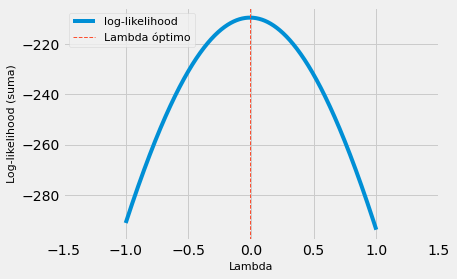

In [116]:
plt.plot(lambdas, loglike, label='log-likelihood')
plt.axvline(l_x, color='C1', lw=1, ls='--', label='Lambda óptimo')
plt.xlim(-1.5, 1.5)
plt.xlabel('Lambda', fontsize=11)
plt.ylabel('Log-likelihood (suma)', fontsize=11)
plt.legend(loc='upper left', fontsize=11)
plt.show()

Comparación de los parámetros que maximizan la función de log-verosimilitud

In [137]:
print('lambda_y:', l_y)
print('lambda_x:', l_x)

lambda_y: 0.23876851669819138
lambda_x: -0.007


El parámetro que maximiza la función de log-verosimilitud del precio **NO** es cercano a los casos especiales (0 ó 1).

El parámetro que maximiza la función de log-verosimilitud de ambdas variables dependientes es muy cercano al 0. A pesar de ser negativo (-0.007), creo que Triplett estaba esperando observar un $\lambda_x$ mucho más lejano al cero.

Regresiones

In [123]:
# Lista de columnas {constate dummies}
cols = ['CONST'] + ['D'+str(y) for y in range(73, 85)]

# ly = lx = 1
m11 = sm.OLS(df['PRICE_l1'], df[cols + ['SPEED_l1','CAP_l1']]).fit()
m11.name = 'm11'

# ly = lx = 0
m00 = sm.OLS(df['PRICE_l0'], df[cols + ['SPEED_l0','CAP_l0']]).fit()
m00.name = 'm00'

# ly = 0, lx = 1
m01 = sm.OLS(df['PRICE_l0'], df[cols + ['SPEED_l1','CAP_l1']]).fit()
m01.name = 'm01'

# ly = 1, lx = 0
m10 = sm.OLS(df['PRICE_l1'], df[cols + ['SPEED_l0','CAP_l0']]).fit()
m10.name = 'm10'

# ly y lx óptimos por log-likelihood (ll)
mll = sm.OLS(df['PRICE_ML'], df[cols + ['SPEED_ML','CAP_ML']]).fit()
mll.name = 'mll'

# En una lisat
m = [m11,m00,m01,m10,mll]

Antes de concluir, creo que las transformaciones de Box-Cox son necesarias porque las variables no se distribuyen normales.

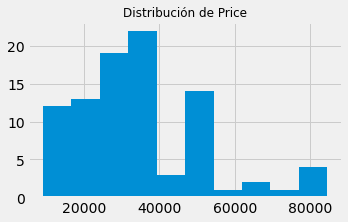

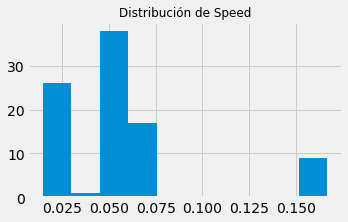

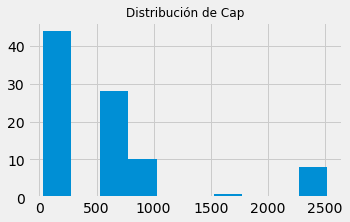

In [133]:
for col in ['PRICE','SPEED','CAP']:
    plt.figure(figsize=(5,3))
    plt.hist(df[col], bins=10)
    plt.title('Distribución de ' + col.capitalize(), fontsize=12)
    plt.show()

En lo personal, me quedaría con el modelo con la transformación Box-Cox usando $\lambda_x = \lambda_y = 0$. Escogí este modelo porque tiene un coeficiente de $R^2$ bastante alto y el criterio de Akaike más bajo de los cuatro modelos que probé.

In [135]:
for model in m:
    print(model.name, '\n R2:', round(model.rsquared, 3), '\n AIC:', round(model.aic, 3), '\n')

m11 
 R2: 0.773 
 AIC: 1928.079 

m00 
 R2: 0.838 
 AIC: 0.636 

m01 
 R2: 0.651 
 AIC: 70.777 

m10 
 R2: 0.838 
 AIC: 1897.303 

mll 
 R2: 0.853 
 AIC: 439.131 



Las distribuciones de las variables transformadas se ven un poco más normales que antes. Me parece que la aproximación no es tan buena como podría ser porque tenemos pocas observaciones.

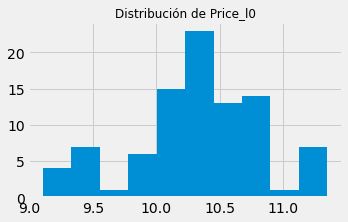

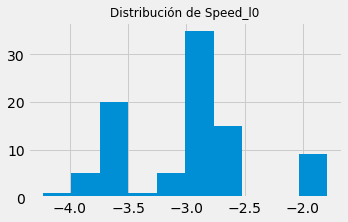

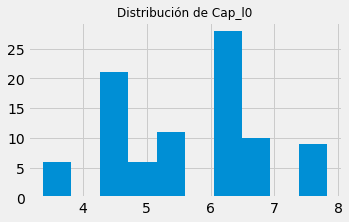

In [136]:
for col in ['PRICE_l0','SPEED_l0','CAP_l0']:
    plt.figure(figsize=(5,3))
    plt.hist(df[col], bins=10)
    plt.title('Distribución de ' + col.capitalize(), fontsize=12)
    plt.show()

A pesar de la mejora en métricas de bondad de ajuste, la interpretación de cambios en las características de las variables se vuelve un poco complicada, pues las variables ahora han sido transformadas para asemejarse a una distribución normal, y sus medias y desviaciones estándar son afectadas por la transformación.

Por suerte, el modelo que escogí usa $\lambda_x = \lambda_y = 0$. Esto se traduce en un modelo log-log y los coeficientes estimados se pueden interpretar como elasticidades.

Considerando esto, podemos construir un índice como en la pregunta 3.

In [176]:
pd.concat([pd.Series(data=[1], index=['D72']), np.exp(m00.params['D73':'D84'])], axis=0)

D72    1.000000
D73    1.016091
D74    0.804362
D75    0.733999
D76    0.658800
D77    0.659251
D78    0.563248
D79    0.463532
D80    0.382830
D81    0.380214
D82    0.385331
D83    0.332293
D84    0.306911
dtype: float64